#### Import keras

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.utils.set_random_seed(0)

# Simple Architectures

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In time series forecasting we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

In [ ]:
# dims of input: [batch, timesteps, features]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, timesteps, feature): ', inputs.shape)
# return_sequences=False, return_state=False
lstm = tf.keras.layers.LSTM(units= 2)
output = lstm(inputs)
print('return_state=False output shape: ',output.shape)

input dim (batch, timesteps, feature):  (32, 10, 4)
return_state=False output shape:  (32, 2)


### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [ ]:
## We can modify the input vector before the rnn cell with TimeDistributed
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features]
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_1 = layers.LSTM(64, return_sequences=True, name='lstm_1')(inputs)
lstm_2 = layers.LSTM(64, return_sequences=True, name='lstm_2')(lstm_1)
# last lstm layer depends in [one to many or  many to many]
lstm_3 = layers.LSTM(64, return_sequences=False, name='lstm_3')(lstm_2)
model = keras.Model(inputs=inputs, outputs=lstm_3, name='rnn_example')
#print(model.summary())
inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

(32, 64)


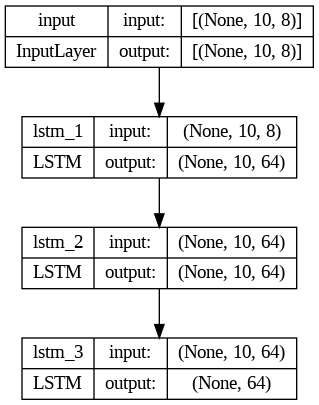

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

# Time Series Data Processing

## Sliding Windows

A sliding window is a technique used to create input-output pairs from time series data. It moves a fixed-size window over the time series data to extract subsequences as input features and the corresponding next value(s) as the target(s). The window size determines the number of past time steps to use as input features, and the horizon determines the number of future time steps to predict.


<img src="https://i.ibb.co/5nvJQB4/split-window.png" alt="cnn" border="0">

We will define two `create_windows` functions, one for `tf.data.Dataset` and another for NumPy, to create input-output pairs from the time series data using sliding windows.


For example if  `data = [0,1,2,3,4,5,6]` :

If we have `window_size=3`, and `horizon=2`, we use **windows of size 3** for predicting **2 steps ahead**.

we are going to use `[0,1,2] (length=window_size=3)` to predict `4`,

We need too create a training data like
```python
[0,1,2], 4
[1,2,3], 5
[2,3,4], 6
```


In [ ]:
def create_windows_np(data, window_size, horizon, shuffle=False):
    """
    Creates a dataset from the given time series data using NumPy.

    Parameters:
    data (np.ndarray): Time series data with one dimension.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    shuffle (bool): Shuffle the windows or not.

    Returns:
    tuple: A tuple containing the input-output pairs (windows, targets) as NumPy arrays.
    """

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])

    X, y = np.array(X), np.array(y)

    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

    return X, y


In [ ]:
X_trial, y_trial = create_windows_np(np.array([0, 1, 2, 3, 4, 5, 6]),
                                     window_size=3,
                                     horizon=2,
                                     shuffle=False)
for ind in range(len(y_trial)):
    print(X_trial[ind, :], y_trial[ind])

[0 1 2] 4
[1 2 3] 5
[2 3 4] 6


In [ ]:
def create_windows_tf(data, window_size, horizon, shuffle=False):
    """
    Creates a dataset from the given time series data using tf.data.Dataset.

    Parameters:
    data (np.ndarray): Time series data with with one dimension.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tf.data.Dataset: The resulting dataset.
    """
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + horizon, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + horizon))
    ts_data = ts_data.map(lambda window: (window[:window_size], window[-1]))
    if shuffle:
        ts_data = ts_data.shuffle(buffer_size=data.shape[0])
    return ts_data

ts_dataset = create_windows_tf(np.array([0, 1, 2, 3, 4, 5, 6]),
                                     window_size=3,
                                     horizon=2,
                                     shuffle=False)

for window, target in ts_dataset:
    print(window.numpy(), target.numpy())

[0 1 2] 4
[1 2 3] 5
[2 3 4] 6


# Simple univariate time series forecasting with RNN

We will use a sine wave as our example time series data. We will generate 1000 data points with a step of 0.1.

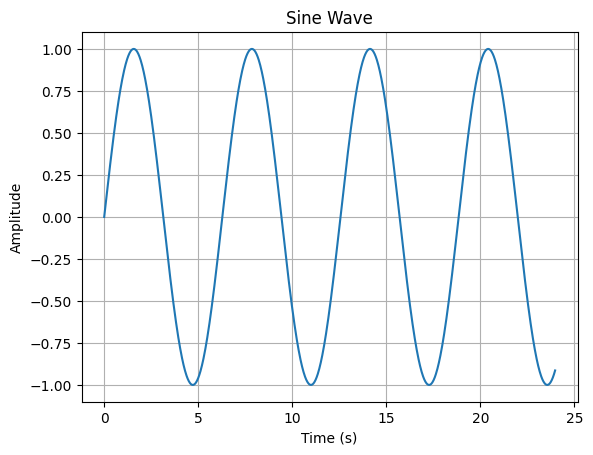

In [ ]:
# Generate sine wave data
t = np.arange(0, 24, 0.02)
y = np.sin(t)

# Plot the sine wave
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sine Wave')
plt.grid(True)
plt.show()

In [ ]:
# train test split
train_size = int(len(y) * 0.8)
ts_train, ts_test = y[:train_size], y[train_size:]
print(ts_test.shape)

(240,)


In [ ]:
window_size = 10
horizon = 10
X_train, y_train = create_windows_np(ts_train, window_size, horizon=2, shuffle=True)
X_test, y_test = create_windows_np(ts_test, window_size, horizon=2, shuffle=False)

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (949, 10)
Test shape: (229, 10)


In [ ]:
inputs_shape = (window_size, 1)

# Define input shape and number of time steps
inputs = keras.layers.Input(shape=(window_size, 1))

# Define LSTM layer with a certain number of units
lstm_out_1 = keras.layers.LSTM(8, return_sequences=False)(inputs)

# Define output layer with a single unit
outputs = keras.layers.Dense(1, activation='linear')(lstm_out_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=7,
    validation_data=(X_test, y_test)
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/7
30/30 [==============================] - 4s 20ms/step - loss: 0.5915 - val_loss: 0.5415
Epoch 2/7
30/30 [==============================] - 0s 5ms/step - loss: 0.3439 - val_loss: 0.2939
Epoch 3/7
30/30 [==============================] - 0s 6ms/step - loss: 0.1640 - val_loss: 0.1233
Epo

In [ ]:
# Use the trained RNN model to make predictions on the test data.
y_pred = model.predict(X_test)

8/8 [==============================] - 0s 2ms/step


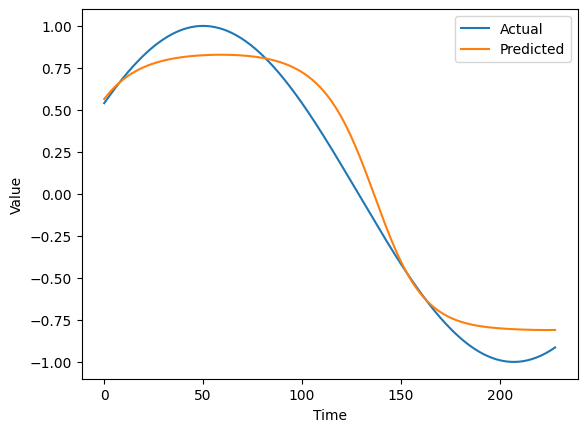

In [ ]:
# visualize the actual vs. predicted values.
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Simple multivariate time series forecasting with RNNs

In [ ]:
import pandas as pd


def create_windows_multivariate_np(data, window_size, horizon, target_col_idx, shuffle=False):
    """
    Creates a dataset from the given time series data using NumPy.

    Parameters:
    data (np.ndarray or pd.DataFrame): Time series data with multiple features.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    target_col_idx (int): The index of the target column in the input data.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tuple: A tuple containing the input-output pairs (X, y) as NumPy arrays.
    """
    if isinstance(data, pd.DataFrame):
        data = data.values

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size, :])
        y.append(data[i+window_size+horizon-1, target_col_idx])

    X, y = np.array(X), np.array(y)

    if shuffle:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

    return X, y


def create_windows_multivariate_tf(data, window_size, horizon, target_col_idx, shuffle=False):
    """
    Creates a dataset from the given time series data using tf.data.Dataset.

    Parameters:
    data (pd.DataFrame): Time series data with multiple features.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    target_col_idx (int): The index of the target column in the input data.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tf.data.Dataset: The resulting dataset.
    """
    if isinstance(data, pd.DataFrame):
        data = data.values

    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + horizon, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + horizon))
    ts_data = ts_data.map(lambda window: (
        window[:window_size], window[-1, target_col_idx]))
    if shuffle:
        ts_data = ts_data.shuffle(buffer_size=data.shape[0])
    return ts_data

In [ ]:
# Generate synthetic multivariate time series data
t = np.arange(0, 24, 0.01)
y1 = np.sin(0.1 * t)
y2 = 0.5 * np.sin(0.2 * t)
data = np.vstack((y1, y2)).T
print(data.shape)

(2400, 2)


In [ ]:
# train test split
train_size = int(data.shape[0] * 0.8)
ts_train, ts_test = data[:train_size], data[train_size:]
print(ts_test.shape)

(480, 2)


In [ ]:
window_size = 10
horizon = 10


train_ds = create_windows_multivariate_tf(
    ts_train, window_size, horizon, target_col_idx=0, shuffle=True)

test_ds = create_windows_multivariate_tf(
    ts_test, window_size, horizon, target_col_idx=0, shuffle=False)

train_ds = train_ds.batch(64)
test_ds = test_ds.batch(100)

In [ ]:
for window, target in train_ds:
    print(window.numpy().shape, target.numpy().shape)
    break

(64, 10, 2) (64,)


In [ ]:
num_features = 2 # (y1, y2)

# Define input shape and number of time steps
inputs = keras.layers.Input(shape=(window_size, num_features))

# Define LSTM layer with a certain number of units
lstm_out_1 = keras.layers.LSTM(8, return_sequences=False)(inputs)

# Define output layer with a single unit
outputs = keras.layers.Dense(1)(lstm_out_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

history = model.fit(
    train_ds,
    epochs=12,
    validation_data=test_ds
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 2)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 8)                 352       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 361 (1.41 KB)
Trainable params: 361 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/12
30/30 [==============================] - 3s 31ms/step - loss: 0.4835 - val_loss: 0.6226
Epoch 2/12
30/30 [==============================] - 0s 7ms/step - loss: 0.2033 - val_loss: 0.3446
Epoch 3/12
30/30 [==============================] - 0s 7ms/step - loss: 0.0828 - val_loss: 0.158

2/2 [==============================] - 0s 7ms/step


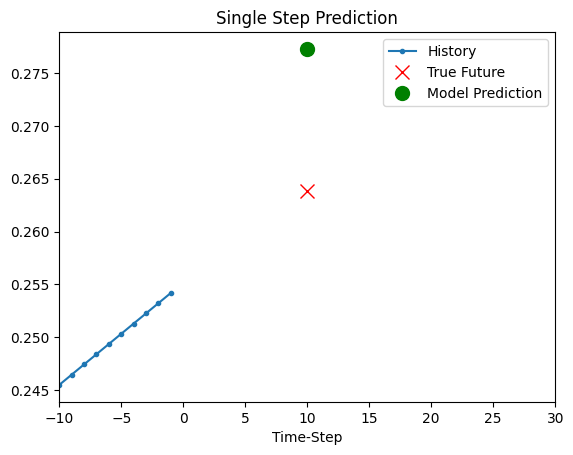

2/2 [==============================] - 0s 4ms/step


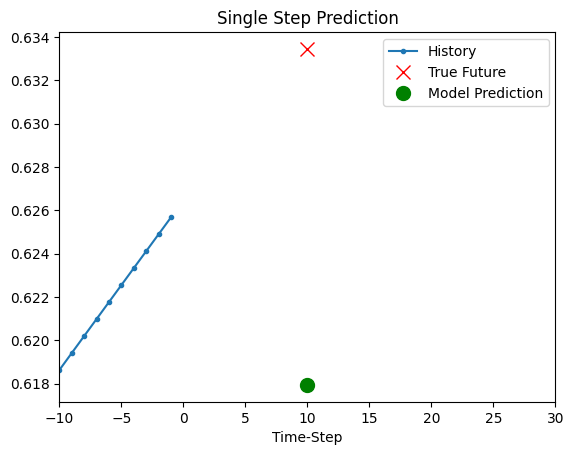

2/2 [==============================] - 0s 7ms/step


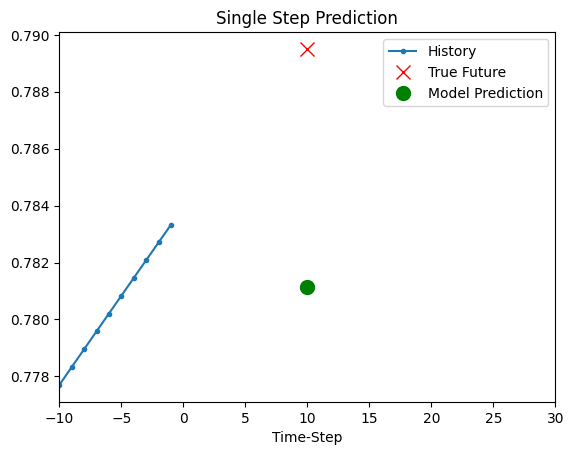

2/2 [==============================] - 0s 7ms/step


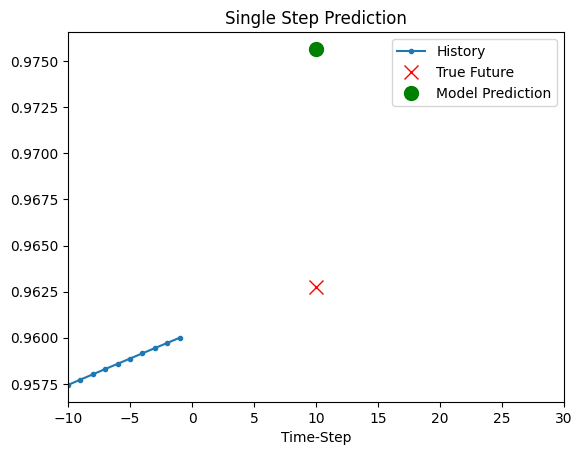

2/2 [==============================] - 0s 5ms/step


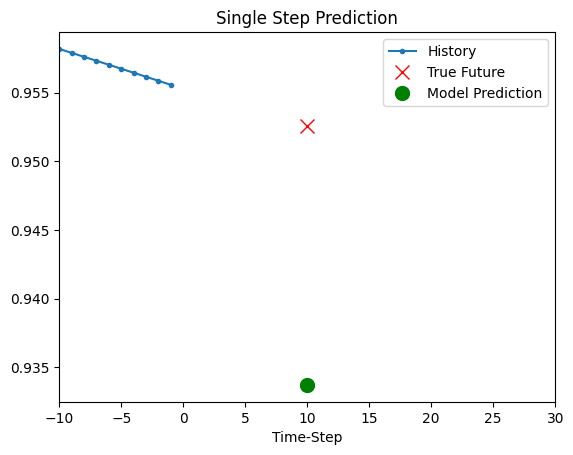

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in train_ds.take(5):
    x_in = x.numpy()
    y_in = y.numpy().flatten()
    pred = model.predict(x)
    show_plot(
        [x_in[0,:, 0], y_in[0], pred.flatten()[0]],
        horizon,
        "Single Step Prediction",
    )

batch:  0
4/4 [==============================] - 0s 4ms/step


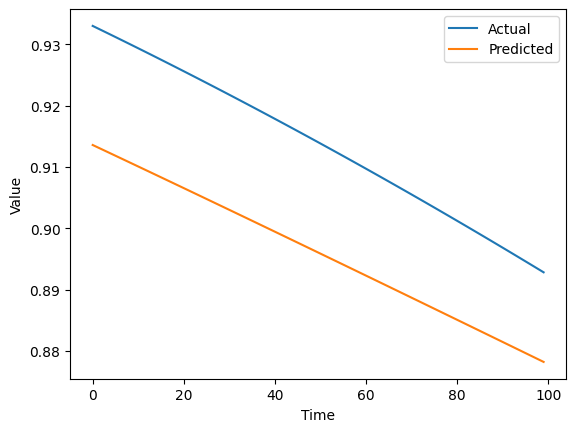

batch:  1
4/4 [==============================] - 0s 3ms/step


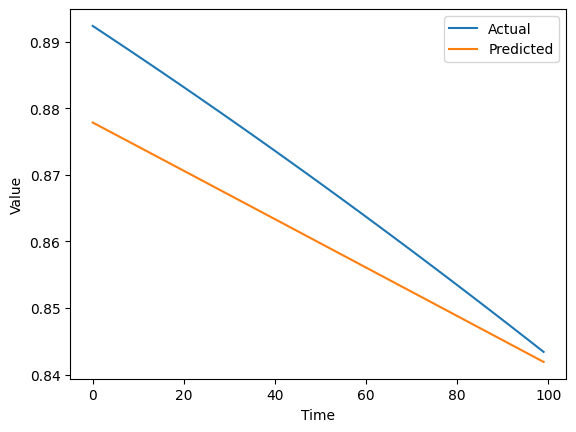

batch:  2
4/4 [==============================] - 0s 3ms/step


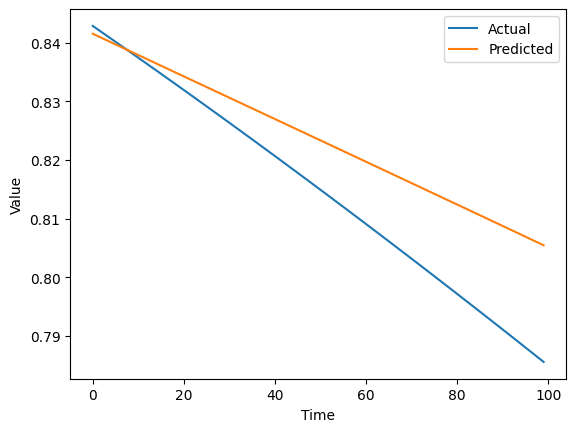

In [ ]:
for i, (x, y) in enumerate(test_ds):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Climate Data Time-Series

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [ ]:
from zipfile import ZipFile
import os


uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path, parse_dates =['Date Time'])
df.head()

13568290/13568290 [==============================] - 0s 0us/step


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 2009 to 2016.
It also shows where anomalies are present, which will be addressed during normalization.

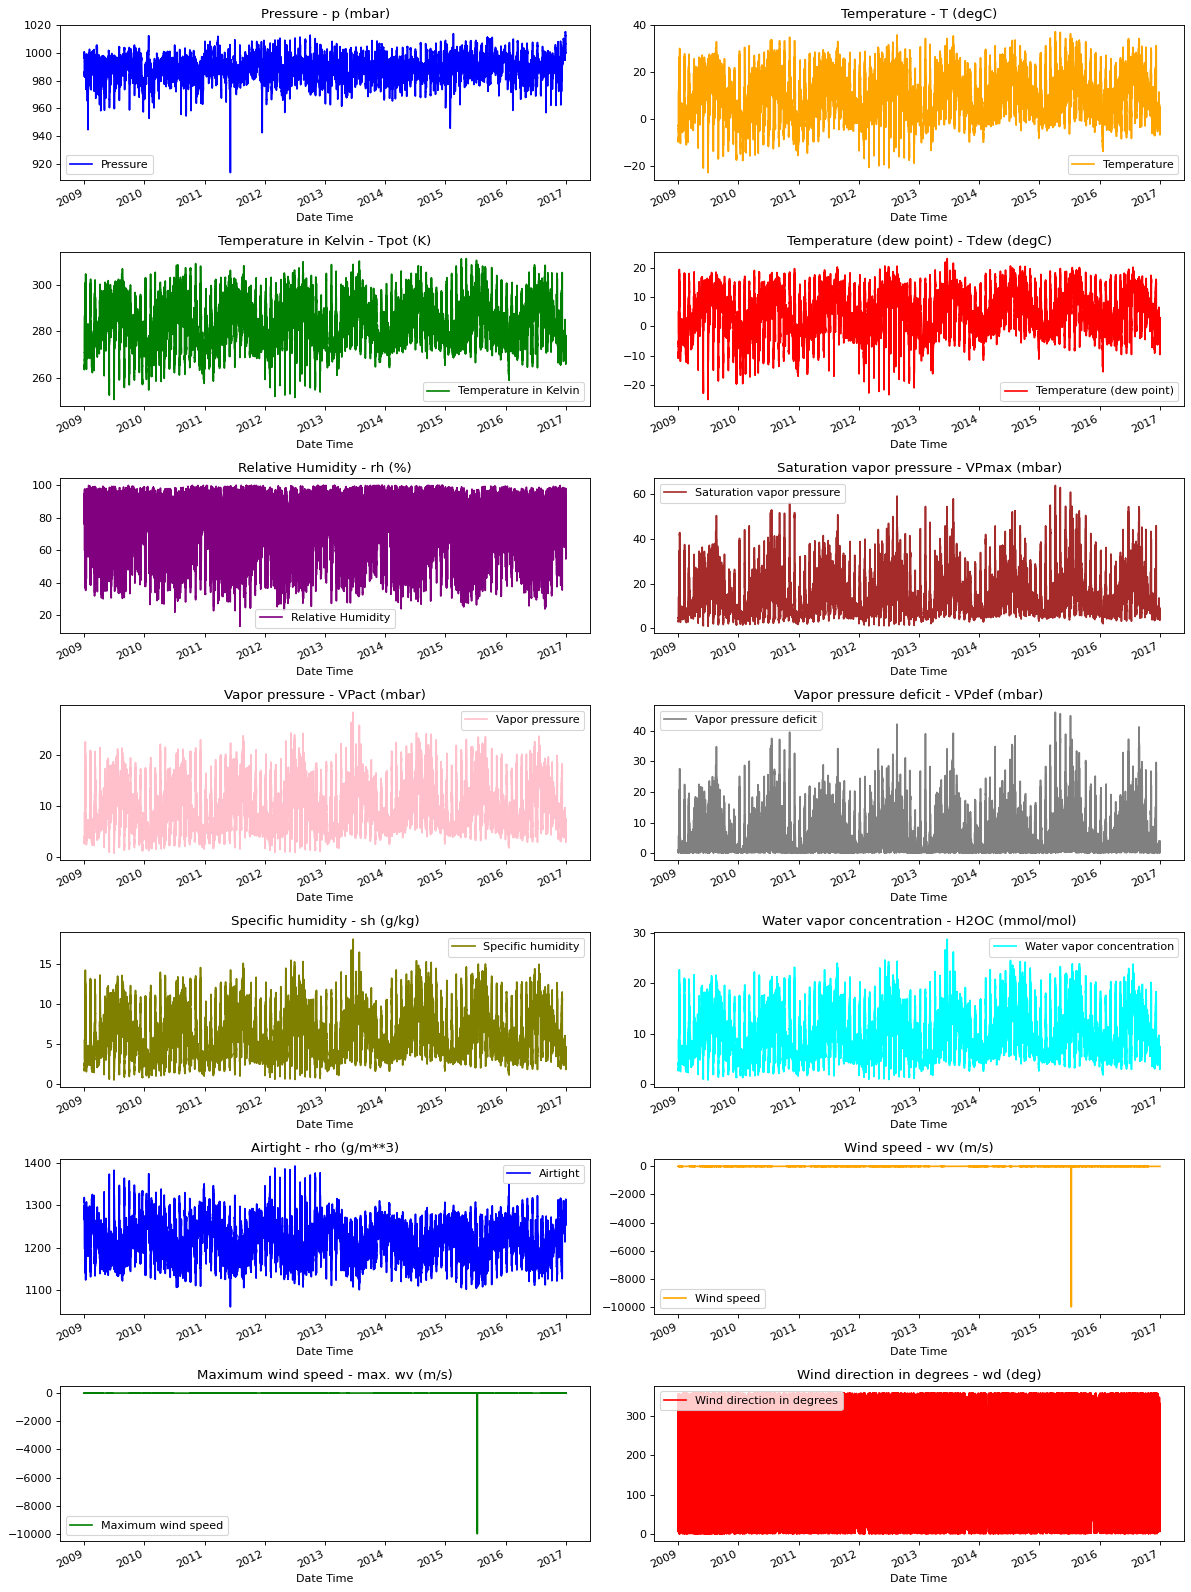

In [ ]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

<ipython-input-24-cf6ad4dd723a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(data.corr())


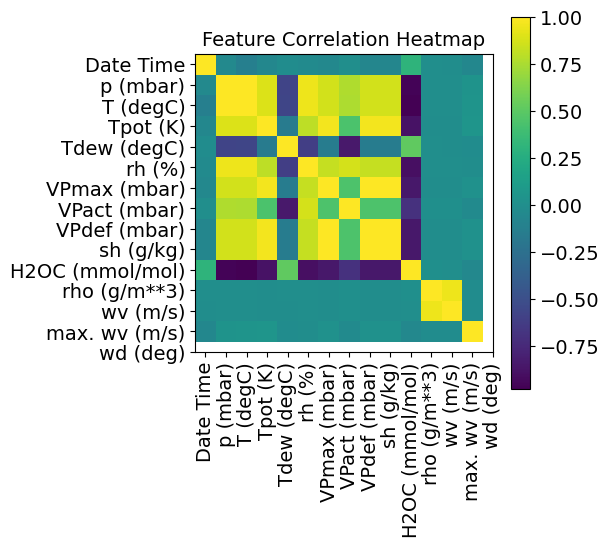

In [ ]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [ ]:
selected_features_title = ['Pressure', 'Temperature', 'Saturation vapor pressure',
                 'Vapor pressure deficit', 'Specific' 'humidity', 'Airtight', 'Wind speed']
selected_features = ['p (mbar)',
 'T (degC)',
 'VPmax (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'rho (g/m**3)',
 'wv (m/s)',
"max. wv (m/s)","wd (deg)" ]

### Data Preprocessing

Here we are picking ~300,000 data points for training. Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours). This data will be
used to predict the temperature after 72 timestamps (76/6=12 hours).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observation will be
used as a label.

In [ ]:
df = df.set_index('Date Time')
## resample by the mean of hour values
df =df.resample('1h').mean().fillna(method='ffill') #
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333


In [ ]:
#Use only important features
df_0 = df.copy()
df = df[selected_features].copy()

In [ ]:
df.values.shape

(70129, 9)

We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [ ]:
# train - test
split_fraction = 0.7
train_split = int(split_fraction * int(len(df)))

train_data = df.iloc[0 : train_split]
val_data = df.iloc[train_split:]
train_data.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.290000,0.670000,150.093333


### Training and validation datasets



In [ ]:
## previous hours to consider
window_size = 6
## Number of hours later to predict
horizon = 12

batch_size = 128

columns = df.columns
# Get the target column index
target_col_idx = columns.get_loc('T (degC)')

dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=True)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)


for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 6, 9)
Target shape: (128,)


### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

### Training

#### Normalization layer
We can normalize the features with [Normalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization).

```python
tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1, dtype=None, mean=None, variance=None, **kwargs
)
```

```python
norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(dataset_train.map(lambda x, y: x))

```



`adapt` computes mean and std of the train data and store them as the layer's weights. `adapt`
 should be called before fit, evaluate, or predict.



In [ ]:
norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1, dtype=None, mean=None, variance=None
)
norm.adapt(dataset_train.map(lambda x, y: x))

print('Unnormalized row: ', df.iloc[:1].values)
print('Normalized row: ', norm(df.iloc[:1]))
print('Normalized df, mean row: ',norm(df.values).numpy().mean(1))
print('Normalized df, std row: ',np.std(norm(df.values).numpy(), 1))

Unnormalized row:  [[ 9.965280e+02 -8.304000e+00  3.260000e+00  2.020000e-01  1.910000e+00
   1.309196e+03  5.200000e-01  1.002000e+00  1.744600e+02]]
Normalized row:  tf.Tensor(
[[[ 0.94999146 -2.0129266  -1.3157951  -0.7864052  -1.5056531
    2.2523437  -1.122278   -1.1587261   0.01908414]]], shape=(1, 1, 9), dtype=float32)
Normalized df, mean row:  [[ 0.06543031  0.04039909  0.02979332  0.01419458  0.0369725  -0.02383644
  -0.30728194 -0.2232463   0.0233389 ]]
Normalized df, std row:  [[ 1.0111923   0.97296965  1.0079112   1.0182787   0.99499863  0.97597647
  43.048386   30.404217    0.983664  ]]


#### Create the model

In [ ]:
norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))


In [ ]:
num_features =  9
inputs_shape = (window_size, num_features)

inputs = keras.layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)
rnn_out = keras.layers.SimpleRNN(32)(inputs_norm)
outputs = keras.layers.Dense(1)(rnn_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 9)]            0         
                                                                 
 normalization_1 (Normaliza  (None, 6, 9)              19        
 tion)                                                           
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1344      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1396 (5.46 KB)
Trainable params: 1377 (5.38 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/25
    376/Unknown - 4s 6ms/step - loss: 59.5442
Epoch 1: val_loss improved from inf to 30.98919, saving model to model_checkpoint.h5
384/384 [==============================] - 6s 13ms/step - loss: 58.9953 - val_loss: 30.9892
Epoch 2/25
382/384 [============================>.] - ETA: 0s - loss: 30.1434
Epoch 2: val_loss improved from 30.98919 to 27.43553, saving model to model_checkpoint.h5
384/384 [==============================] - 3s 7ms/step - loss: 30.1223 - val_loss: 27.4355
Epoch 3/25
383/384 [============================>.] - ETA: 0s - loss: 27.4329
Epoch 3: val_loss improved from 27.43553 to 25.85275, saving model to model_checkpoint.h5
384/384 [==============================] - 3s 7ms/step - loss: 27.4212 - val_loss: 25.8528
Epoch 4/25
384/384 [==============================] - ETA: 0s - loss: 26.0644
Epoch 4: val_loss did not improve from 25.85275
384/384 [==============================] - 3s 8ms/step - loss: 26.0644 - val_loss: 26.4253
Epoch 5/25
383/384 [===========

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

16/16 [==============================] - 0s 2ms/step


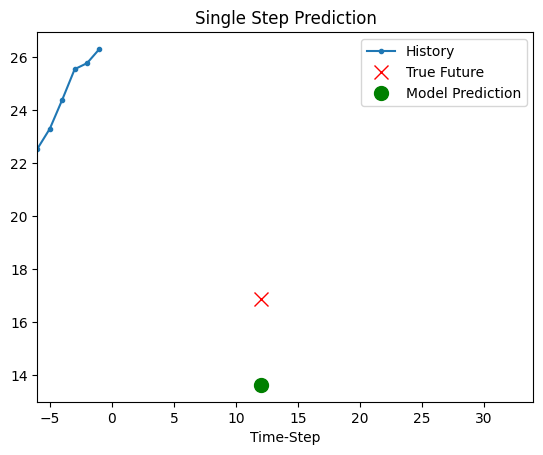

16/16 [==============================] - 0s 2ms/step


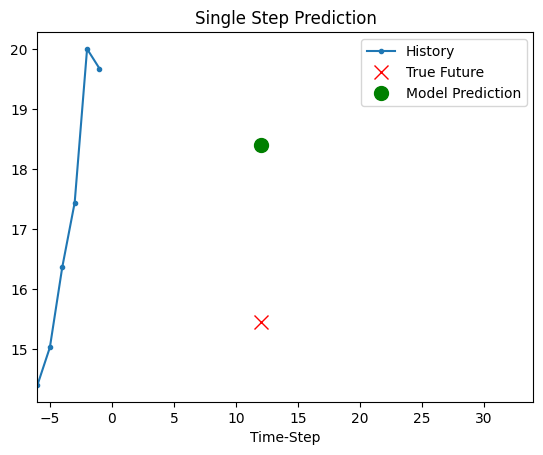

16/16 [==============================] - 0s 2ms/step


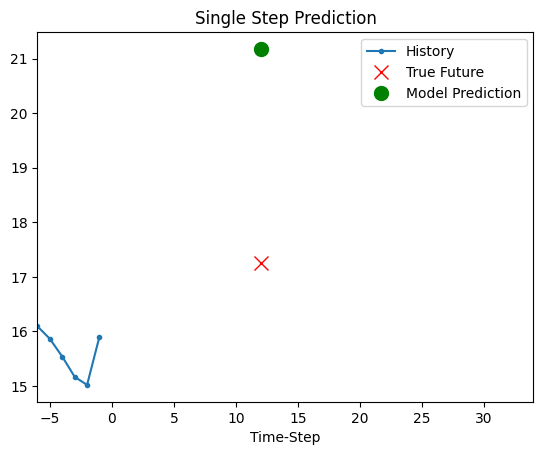

16/16 [==============================] - 0s 2ms/step


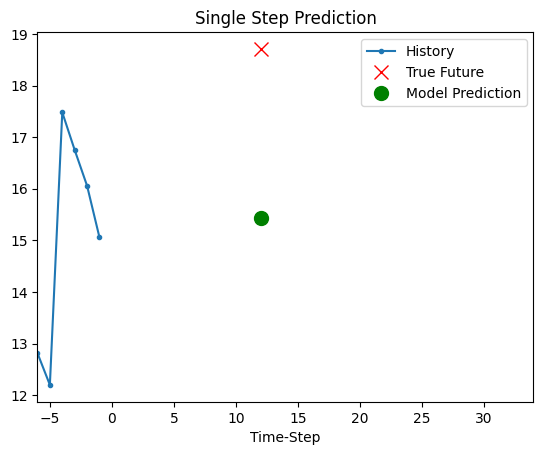

16/16 [==============================] - 0s 3ms/step


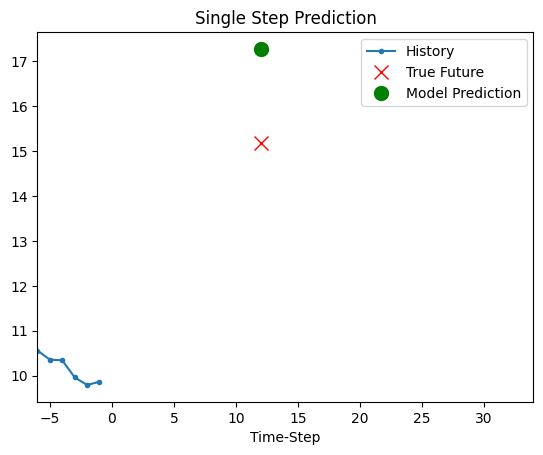

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )

batch:  0
16/16 [==============================] - 0s 2ms/step


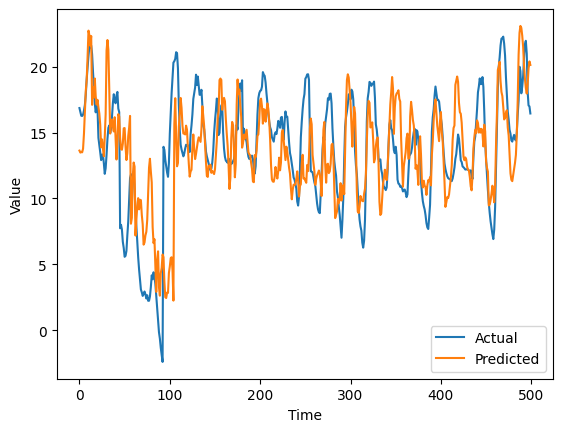

batch:  1
16/16 [==============================] - 0s 2ms/step


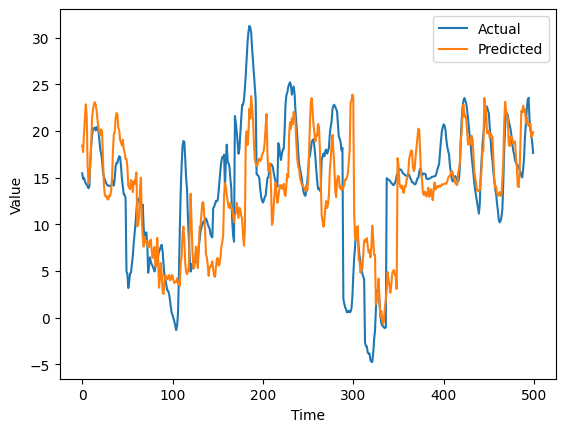

batch:  2
16/16 [==============================] - 0s 2ms/step


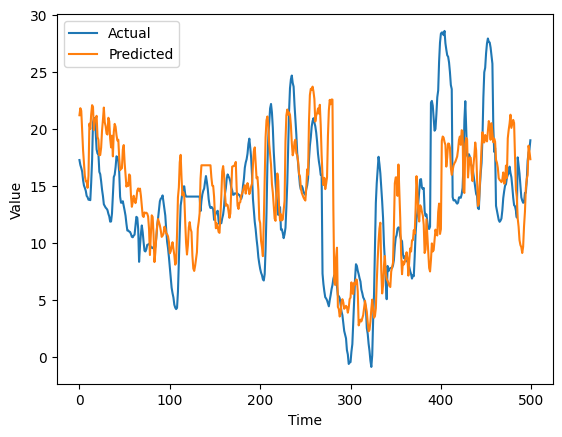

In [ ]:

for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

#### Question 1:  Change the `keras.layers.SimpleRNN` layer to `keras.layers.LSTM` and to `keras.layers.GRU` and compare the results
You can also set the `recurrent_dropout` parameter

```python
tf.keras.layers.x(
    units,
    dropout=0.0,
    recurrent_dropout=0.0)
```

In [ ]:
num_features = 9
inputs_shape = (window_size, num_features)


norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)

## complete the code
lstm_out = layers.GRU(64)(inputs_norm)

outputs = layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [ ]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
384/384 [==============================] - 4s 5ms/step - loss: 44.7367 - val_loss: 26.8205
Epoch 2/25
384/384 [==============================] - 2s 4ms/step - loss: 27.1184 - val_loss: 26.1939
Epoch 3/25
384/384 [==============================] - 2s 4ms/step - loss: 25.6274 - val_loss: 24.7231
Epoch 4/25
384/384 [==============================] - 2s 4ms/step - loss: 24.6954 - val_loss: 24.4397
Epoch 5/25
384/384 [==============================] - 2s 4ms/step - loss: 24.1357 - val_loss: 23.9529
Epoch 6/25
384/384 [==============================] - 2s 5ms/step - loss: 23.6177 - val_loss: 22.8373
Epoch 7/25
384/384 [==============================] - 2s 4ms/step - loss: 23.2506 - val_loss: 22.7965
Epoch 8/25
384/384 [==============================] - 2s 4ms/step - loss: 23.0728 - val_loss: 23.7253
Epoch 9/25
384/384 [==============================] - 2s 4ms/step - loss: 22.6263 - val_loss: 23.4440
Epoch 10/25
384/384 [==============================] - 2s 4ms/step - loss: 22.3932

16/16 [==============================] - 0s 2ms/step


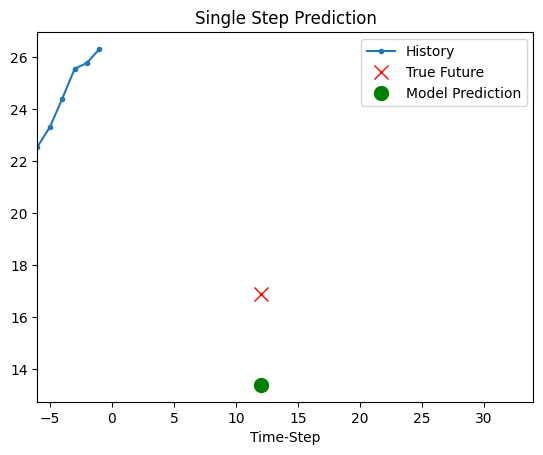

16/16 [==============================] - 0s 2ms/step


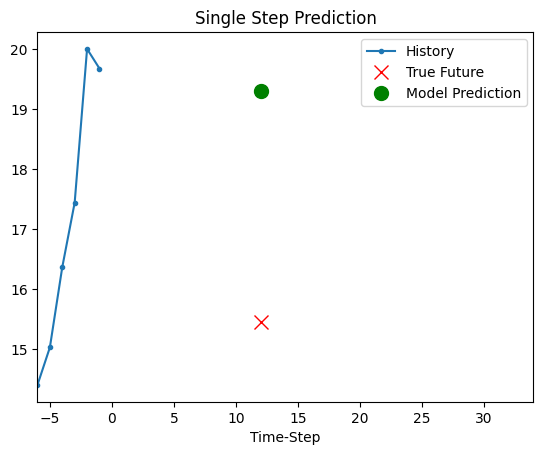

16/16 [==============================] - 0s 2ms/step


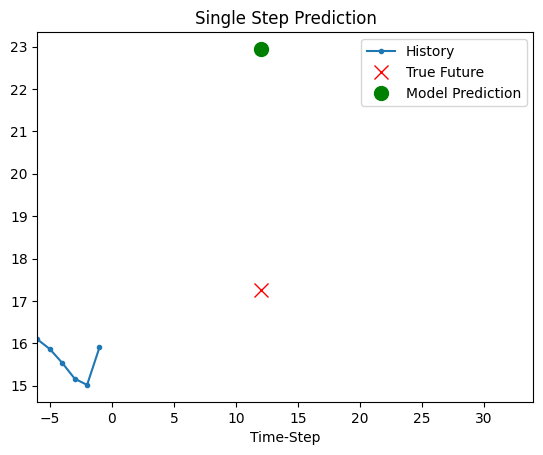

16/16 [==============================] - 0s 2ms/step


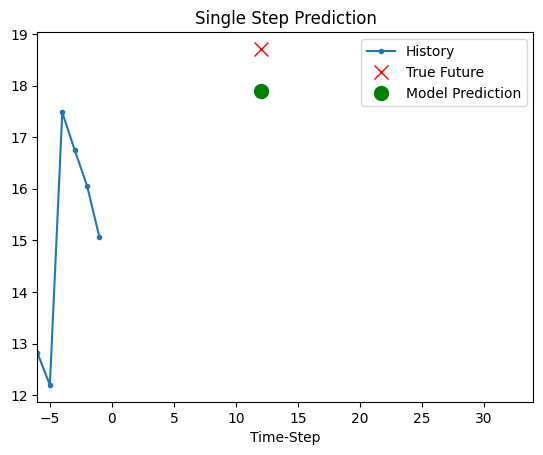

16/16 [==============================] - 0s 2ms/step


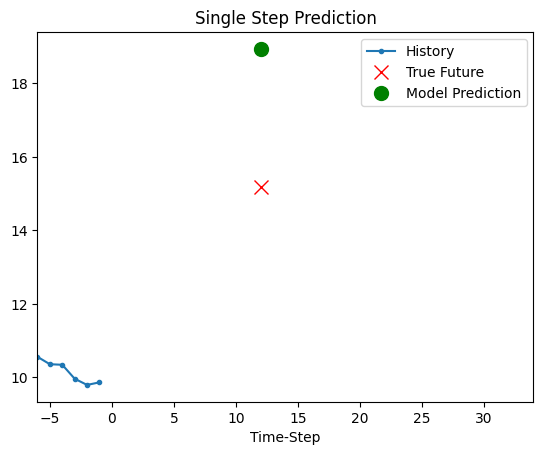

batch:  0
16/16 [==============================] - 0s 3ms/step


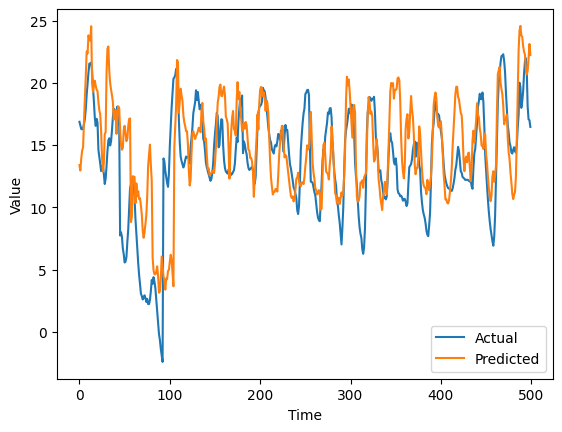

batch:  1
16/16 [==============================] - 0s 3ms/step


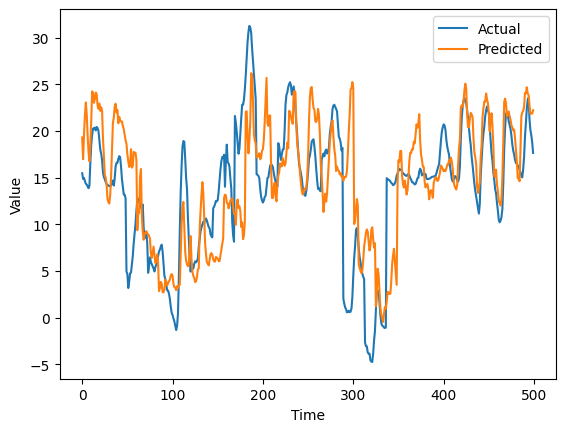

batch:  2
16/16 [==============================] - 0s 3ms/step


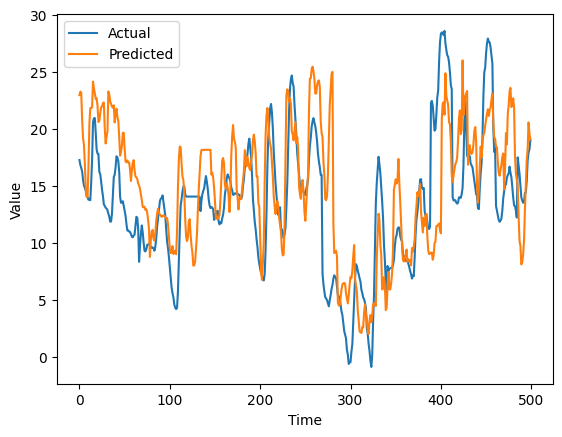

In [ ]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Feature Engineering

Wind velocity
One thing that should stand out is the min value of the wind velocity, wv (m/s) and max. wv (m/s) columns. This -9999 is likely erroneous. There's a separate wind direction column, so the velocity should be >=0. Replace it with zeros:

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
df['wv (m/s)'] = wv

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0
df['max. wv (m/s)'] = max_wv


But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [ ]:
wv = df.pop('wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Similarly the Date Time column is very useful, but not in this string form. Start by converting it to seconds:


Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" and "Time of year" signals:

In [ ]:
from datetime import datetime
timestamp_s = df.index.map(datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [ ]:
df.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),max. wv (m/s),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,1.002000,-0.517571,0.050201,-0.997320,0.096734,-1.776611e-12,1.000000,0.009332,0.999956
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.711667,-0.313897,0.041790,-0.705442,0.093917,2.588190e-01,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.606667,-0.237713,-0.071845,-0.580723,-0.175515,5.000000e-01,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.606667,-0.162723,0.068793,-0.558784,0.236231,7.071068e-01,0.707107,0.011483,0.999934
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.670000,-0.251383,0.144591,-0.580782,0.334054,8.660254e-01,0.500000,0.012199,0.999926


In [ ]:
# train - test
split_fraction = 0.7
train_split = int(split_fraction * int(len(df)))

train_data = df.iloc[0 : train_split]
val_data = df.iloc[train_split:]
train_data.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),max. wv (m/s),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,1.002000,-0.517571,0.050201,-0.997320,0.096734,-1.776611e-12,1.000000,0.009332,0.999956
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.711667,-0.313897,0.041790,-0.705442,0.093917,2.588190e-01,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.606667,-0.237713,-0.071845,-0.580723,-0.175515,5.000000e-01,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.606667,-0.162723,0.068793,-0.558784,0.236231,7.071068e-01,0.707107,0.011483,0.999934
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.670000,-0.251383,0.144591,-0.580782,0.334054,8.660254e-01,0.500000,0.012199,0.999926


In [ ]:
## previous hours to consider
window_size = 6
## Number of hours later to predict
horizon = 12

batch_size = 128


# Get the target column index
target_col_idx = columns.get_loc('T (degC)')

dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=True)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)


for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 6, 15)
Target shape: (128,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

### Question 2:  Use the same model as before and compare the results


In [ ]:
norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

In [ ]:
num_features = 15
inputs_shape = (window_size, num_features)

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)
## complete the code
lstm_out = layers.GRU(64)(inputs_norm)
outputs = layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [ ]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
384/384 [==============================] - 6s 11ms/step - loss: 37.1011 - val_loss: 18.0029
Epoch 2/25
384/384 [==============================] - 2s 4ms/step - loss: 18.3643 - val_loss: 16.9535
Epoch 3/25
384/384 [==============================] - 2s 4ms/step - loss: 17.2449 - val_loss: 17.0606
Epoch 4/25
384/384 [==============================] - 2s 4ms/step - loss: 16.5677 - val_loss: 16.0900
Epoch 5/25
384/384 [==============================] - 2s 4ms/step - loss: 16.1281 - val_loss: 16.2624
Epoch 6/25
384/384 [==============================] - 2s 4ms/step - loss: 15.7503 - val_loss: 16.0815
Epoch 7/25
384/384 [==============================] - 2s 5ms/step - loss: 15.4022 - val_loss: 16.5468
Epoch 8/25
384/384 [==============================] - 2s 4ms/step - loss: 15.0977 - val_loss: 16.0062
Epoch 9/25
384/384 [==============================] - 2s 4ms/step - loss: 14.8496 - val_loss: 15.5485
Epoch 10/25
384/384 [==============================] - 2s 4ms/step - loss: 14.569

16/16 [==============================] - 0s 3ms/step


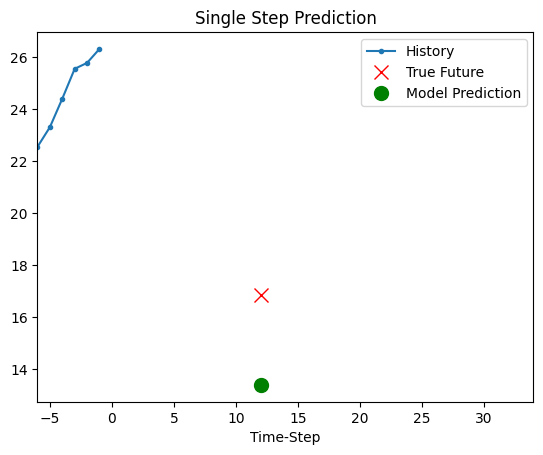

16/16 [==============================] - 0s 3ms/step


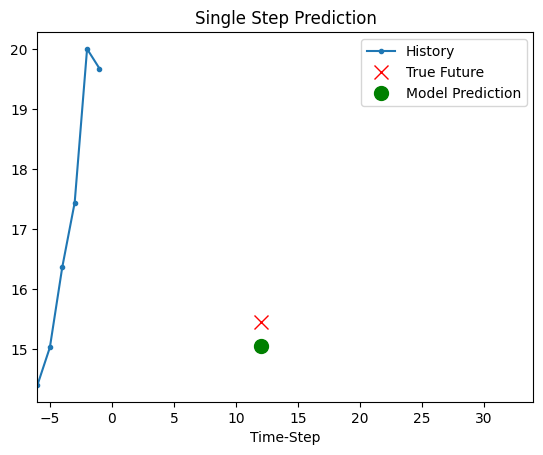

16/16 [==============================] - 0s 3ms/step


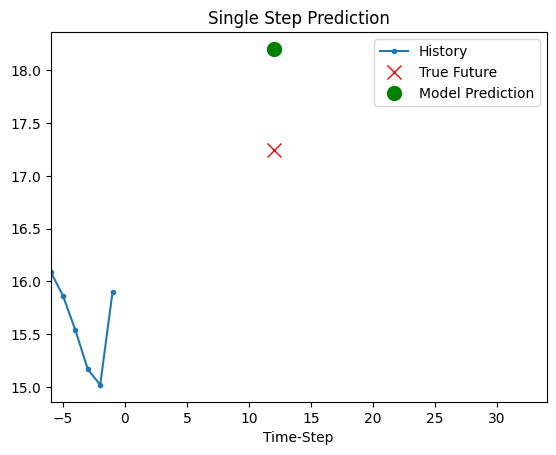

16/16 [==============================] - 0s 2ms/step


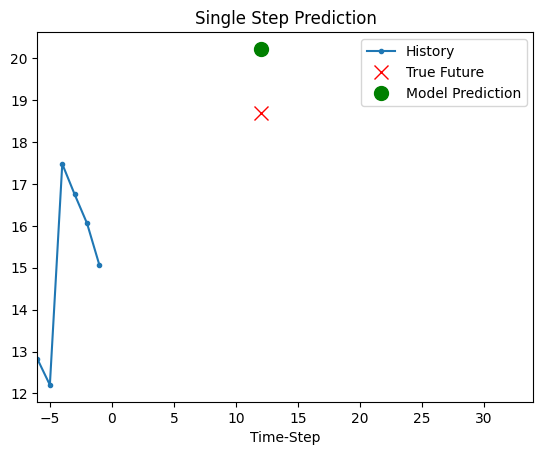

16/16 [==============================] - 0s 2ms/step


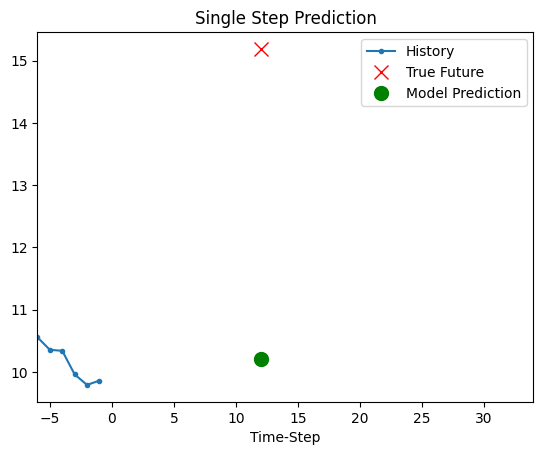

batch:  0
16/16 [==============================] - 0s 2ms/step


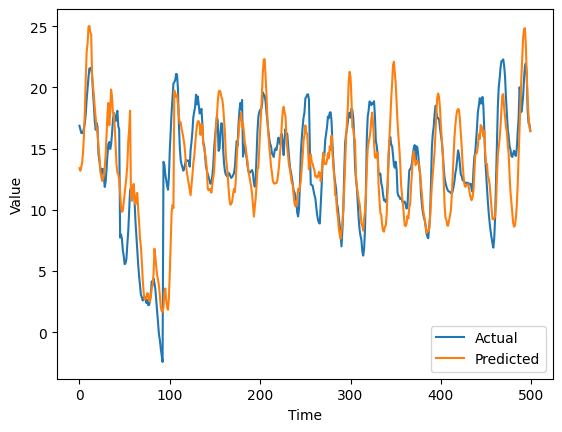

batch:  1
16/16 [==============================] - 0s 2ms/step


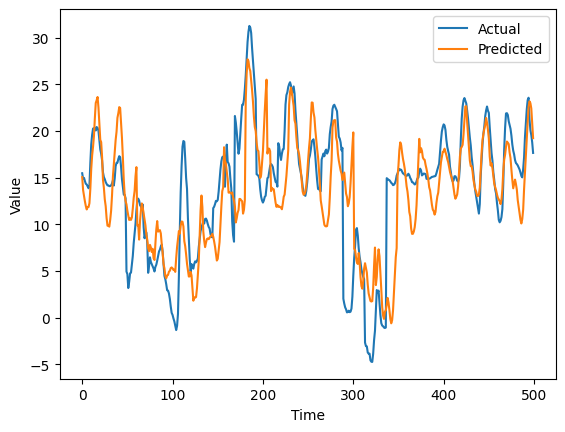

batch:  2
16/16 [==============================] - 0s 2ms/step


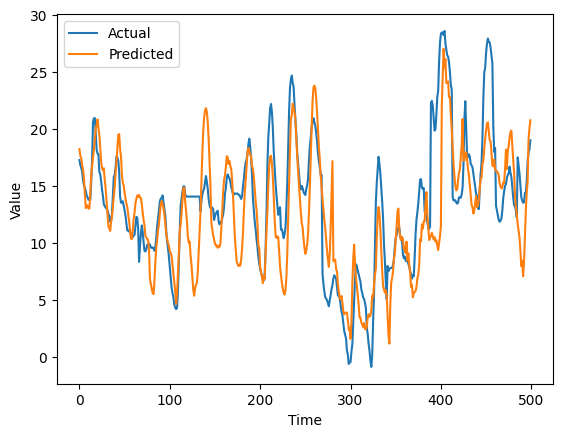

In [ ]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Question 3:  Create a deep model stacking two recurrent layers

In [ ]:
num_features = 15
inputs_shape = (window_size, num_features)


norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)

## complete the code
l_1 = keras.layers.LSTM(64, return_sequences=True)(inputs_norm)
l_2 = keras.layers.LSTM(64, return_sequences=False)(l_1)

outputs = keras.layers.Dense(1)(l_2)


model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [ ]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
384/384 [==============================] - 7s 8ms/step - loss: 33.3075 - val_loss: 18.5684
Epoch 2/25
384/384 [==============================] - 2s 6ms/step - loss: 18.0250 - val_loss: 17.2011
Epoch 3/25
384/384 [==============================] - 2s 6ms/step - loss: 16.5628 - val_loss: 16.6390
Epoch 4/25
384/384 [==============================] - 2s 6ms/step - loss: 15.7540 - val_loss: 16.5158
Epoch 5/25
384/384 [==============================] - 3s 7ms/step - loss: 15.1649 - val_loss: 16.5668
Epoch 6/25
384/384 [==============================] - 2s 6ms/step - loss: 14.5528 - val_loss: 16.7805
Epoch 7/25
384/384 [==============================] - 2s 6ms/step - loss: 13.9708 - val_loss: 16.4364
Epoch 8/25
384/384 [==============================] - 2s 6ms/step - loss: 13.4934 - val_loss: 16.2799
Epoch 9/25
384/384 [==============================] - 2s 6ms/step - loss: 12.9105 - val_loss: 16.7656
Epoch 10/25
384/384 [==============================] - 3s 7ms/step - loss: 12.2989

16/16 [==============================] - 1s 3ms/step


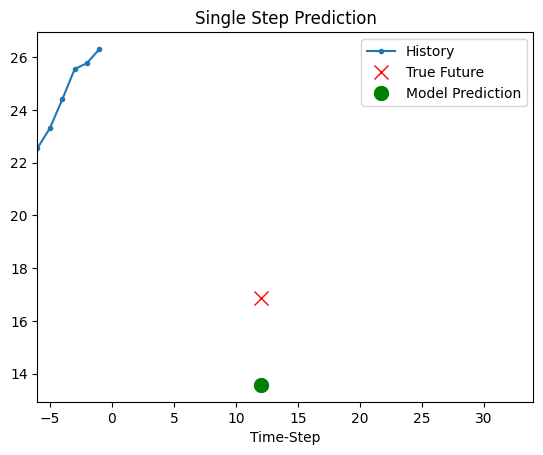

16/16 [==============================] - 0s 3ms/step


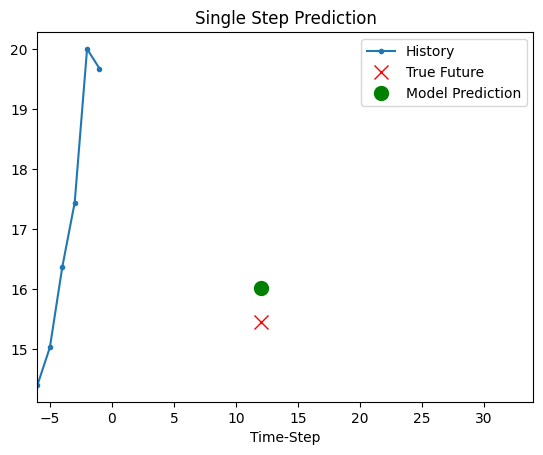

16/16 [==============================] - 0s 3ms/step


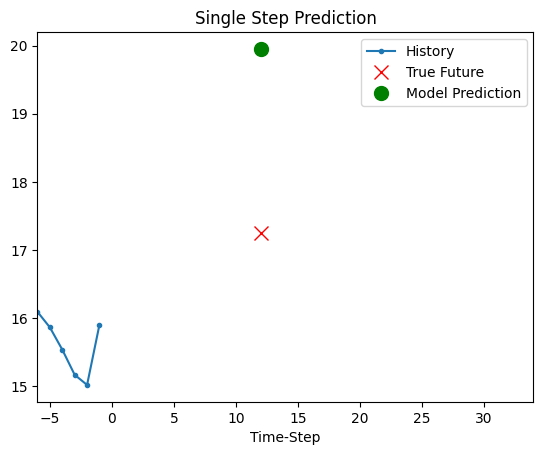

16/16 [==============================] - 0s 3ms/step


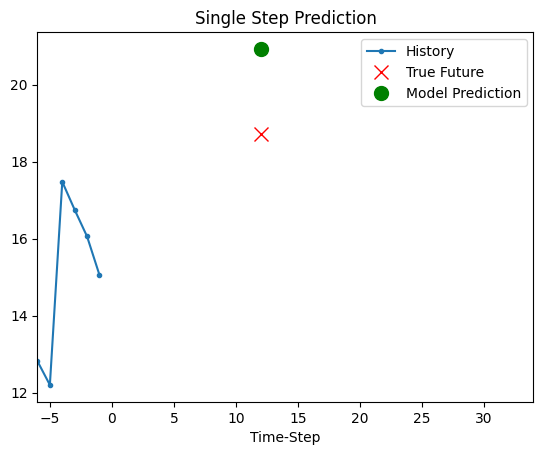

16/16 [==============================] - 0s 3ms/step


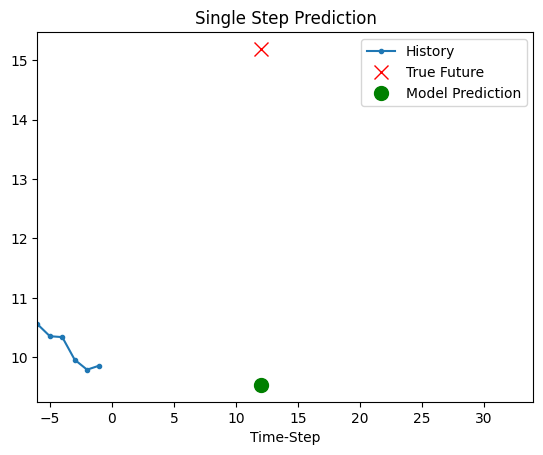

batch:  0
16/16 [==============================] - 0s 3ms/step


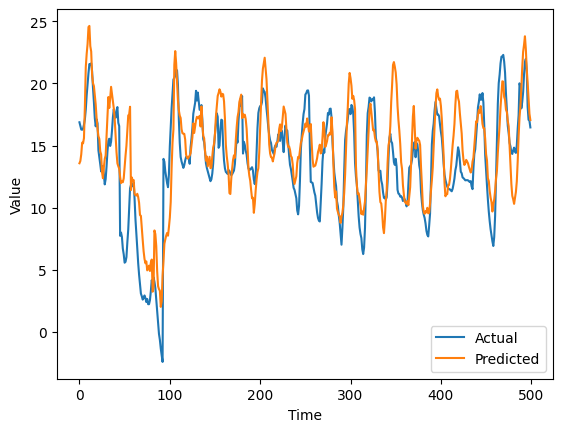

batch:  1
16/16 [==============================] - 0s 3ms/step


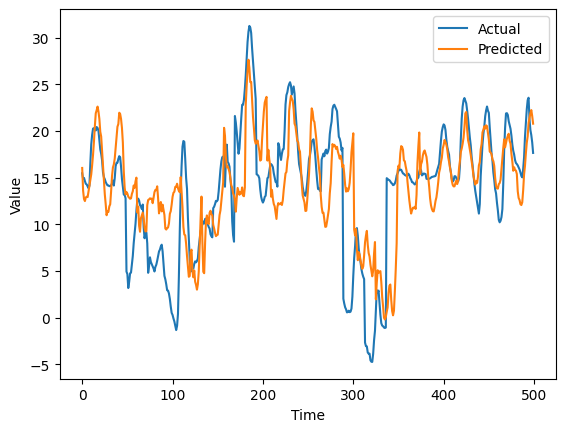

batch:  2
16/16 [==============================] - 0s 3ms/step


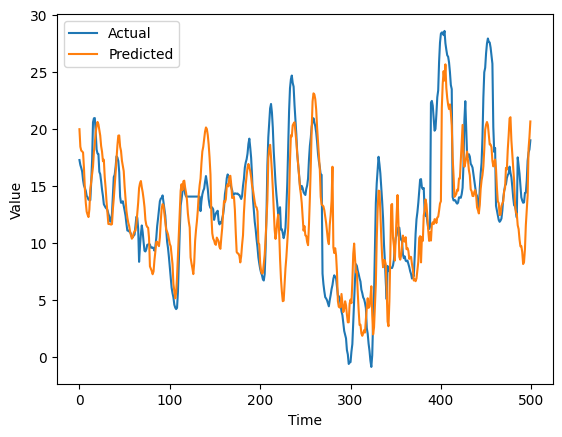

In [ ]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Question 5:  Obtain a good model for predicting the temperature in 24h

Try different architectures and different values for `window_size`

In [ ]:
horizon = 24

In [ ]:
## previous hours to consider
window_size = 48

batch_size = 128


# Get the target column index
target_col_idx = columns.get_loc('T (degC)')

dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=True)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)


for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 48, 15)
Target shape: (128,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
norm = tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

In [ ]:
inputs = layers.Input(shape=(window_size, num_features))
inputs_norm = norm(inputs)


l_1 = keras.layers.GRU(128, return_sequences=False)(inputs_norm)
l_1 = layers.Dropout(0.4)(l_1)
outputs = keras.layers.Dense(1)(l_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/25
    378/Unknown - 4s 5ms/step - loss: 40.1322
Epoch 1: val_loss improved from inf to 25.44307, saving model to model_checkpoint.h5
383/383 [==============================] - 10s 20ms/step - loss: 40.0210 - val_loss: 25.4431
Epoch 2/25
381/383 [============================>.] - ETA: 0s - loss: 27.9972
Epoch 2: val_loss did not improve from 25.44307
383/383 [==============================] - 3s 7ms/step - loss: 27.9976 - val_loss: 26.5758
Epoch 3/25
381/383 [============================>.] - ETA: 0s - loss: 24.4778
Epoch 3: val_loss did not improve from 25.44307
383/383 [==============================] - 2s 6ms/step - loss: 24.4897 - val_loss: 27.6092
Epoch 4/25
376/383 [============================>.] - ETA: 0s - loss: 21.7595
Epoch 4: val_loss did not improve from 25.44307
383/383 [==============================] - 2s 5ms/step - loss: 21.7233 - val_loss: 27.8969


16/16 [==============================] - 0s 2ms/step


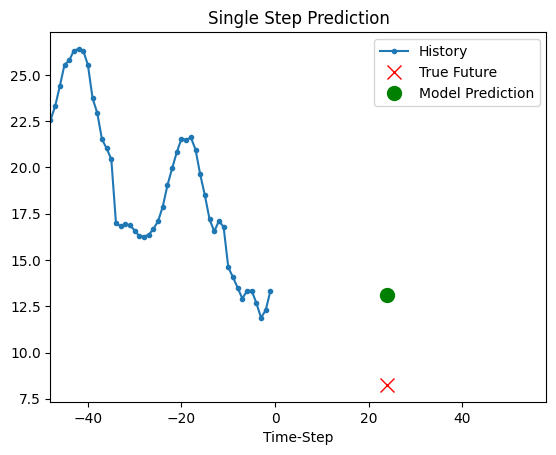

16/16 [==============================] - 0s 3ms/step


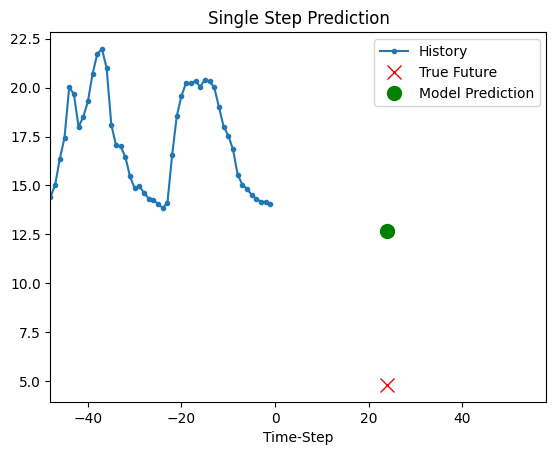

16/16 [==============================] - 0s 3ms/step


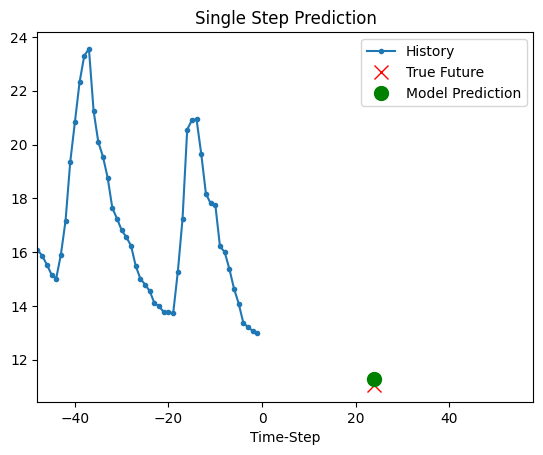

16/16 [==============================] - 0s 3ms/step


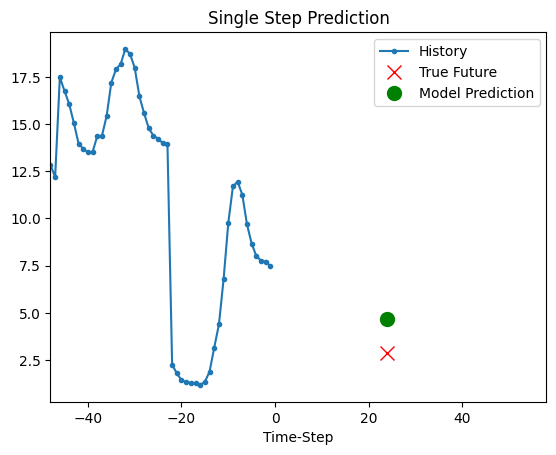

16/16 [==============================] - 0s 3ms/step


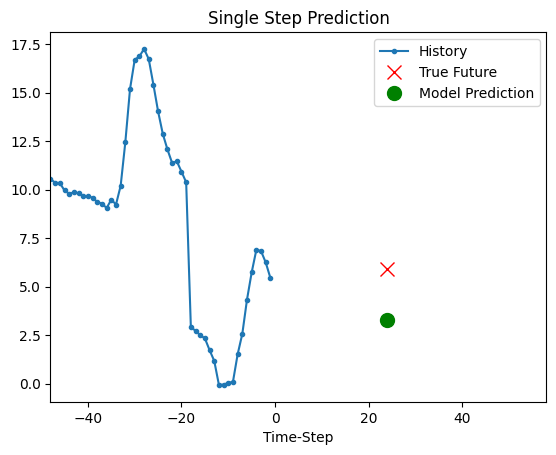

batch:  0
16/16 [==============================] - 0s 3ms/step


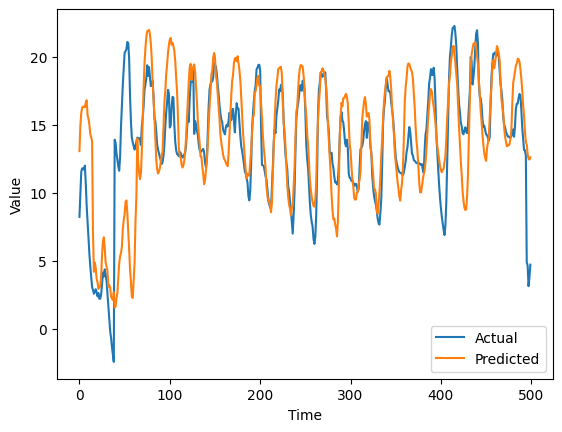

batch:  1
16/16 [==============================] - 0s 3ms/step


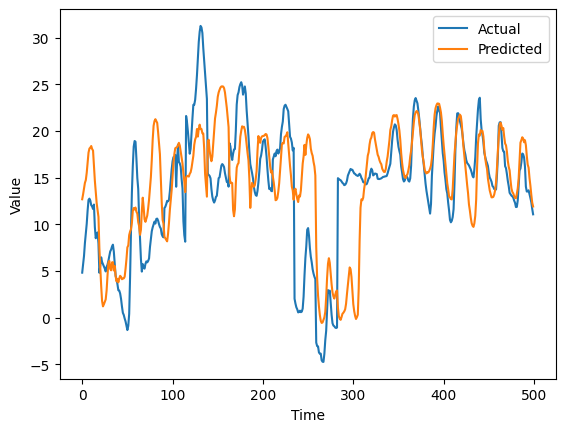

batch:  2
16/16 [==============================] - 0s 3ms/step


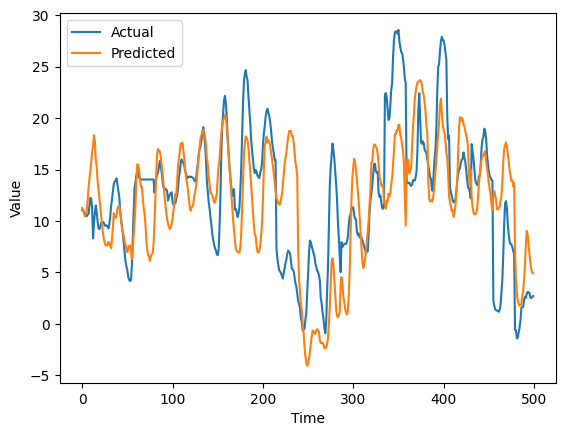

In [ ]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()